In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GMM
from sklearn.cluster import DBSCAN
#from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV

In [9]:
# 데이터 불러오기
data = pd.read_csv("kobe_data.csv")

In [10]:
data.shape

(30697, 25)

In [3]:
data.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [4]:
#필요 없는거 제거
data.drop(['lat', 'lon', 'team_id', 'team_name'], axis=1, inplace=True)

## Data Visualization

위치에 따른 성공 / 실패

(-100, 1000)

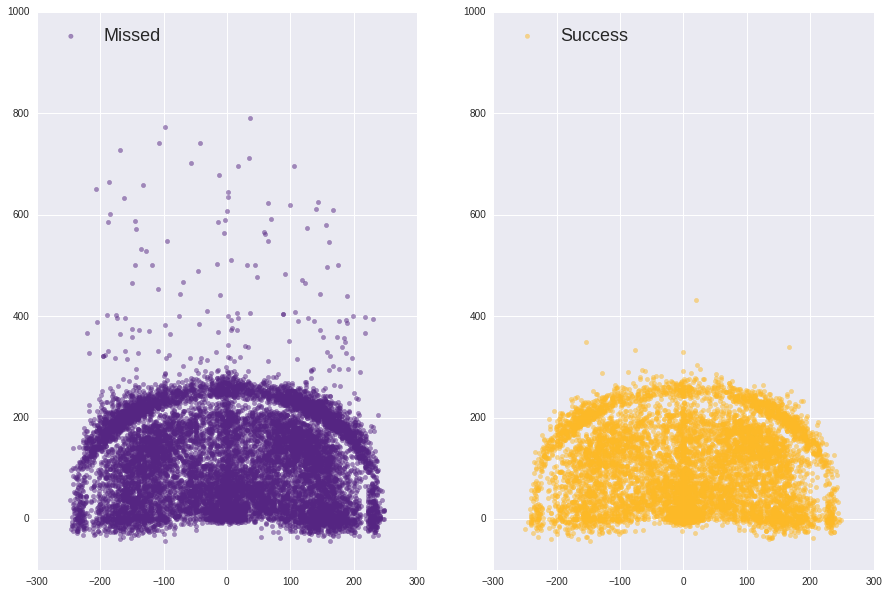

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.scatter(data[data.shot_made_flag==0].loc_x,data[data.shot_made_flag==0].loc_y,color='#552582',label='Missed',alpha=0.5)
plt.legend(fontsize=18,loc='upper left')
plt.ylim(-100,1000)

plt.subplot(122)
plt.scatter(data[data.shot_made_flag==1].loc_x,data[data.shot_made_flag==1].loc_y,color='#FDB927',label='Success',alpha=0.5)
plt.legend(fontsize=18,loc='upper left')
plt.ylim(-100,1000)

add features

In [6]:
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek'] = data['game_date_DT'].dt.dayofweek
data['dayOfYear'] = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd'] = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart'] = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

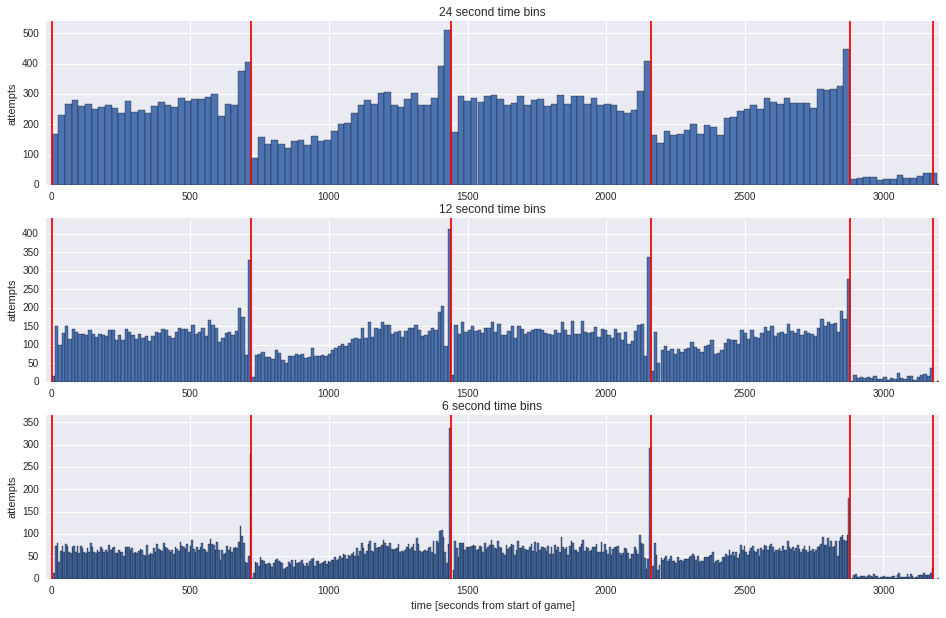

In [7]:
#%% plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 10)

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

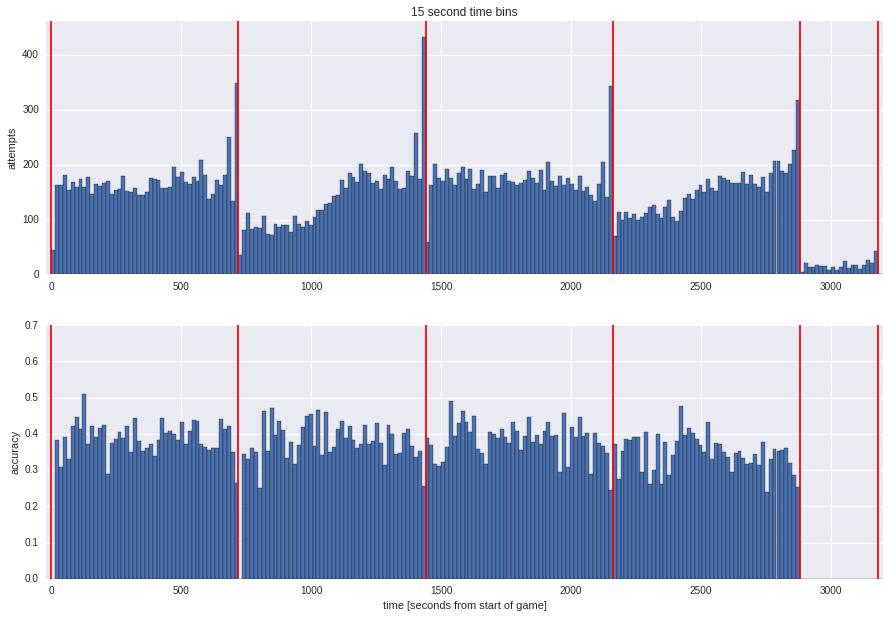

In [8]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)

binSizeInSeconds = 15
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.ix[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])
 
plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

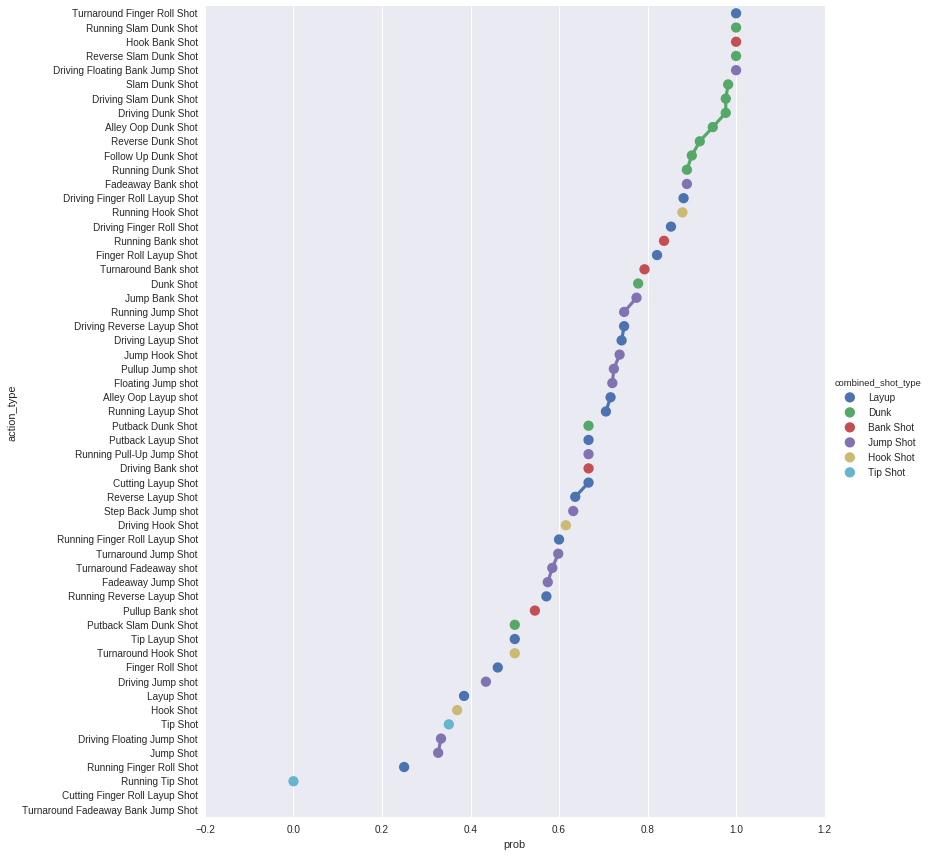

In [9]:
tup = [data['action_type'],data['combined_shot_type'],data['shot_made_flag']]
tup = pd.concat(tup,axis = 1)
#df_new = pd.DataFrame(columns=['action_type','combined_shot_type','probability_success'])
grouped = tup.groupby(['action_type','combined_shot_type']).agg([np.sum,'count']).reset_index()
prob =  grouped['shot_made_flag']['sum']/grouped['shot_made_flag']['count']
a = {'action_type':grouped.action_type,'combined_shot_type':grouped.combined_shot_type,'prob':prob}
df = pd.DataFrame(a)
df.sort_values(['prob'], ascending=[False], inplace=True)
sns.factorplot(x='prob', y='action_type',hue = 'combined_shot_type', data=df, size=12)

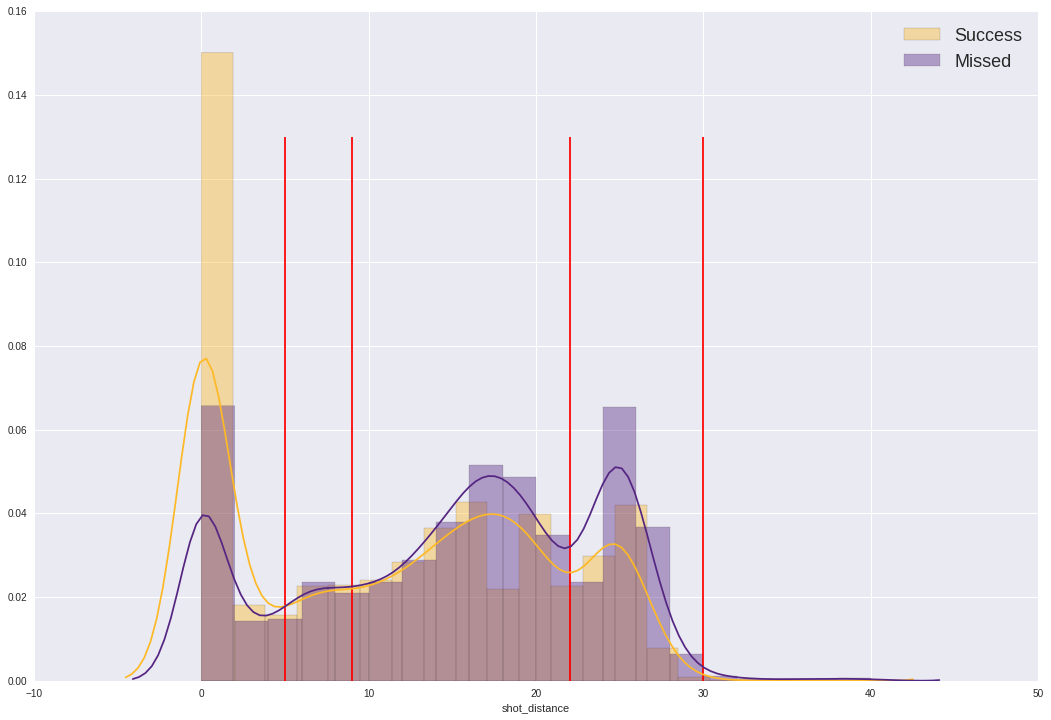

In [10]:
dist_df = data[data.shot_distance <= 40]
plt.figure(figsize=(18,12))
sns.distplot(dist_df[dist_df['shot_made_flag']==1].shot_distance,bins=20,color='#FDB927',kde=True,label='Success')
sns.distplot(dist_df[dist_df['shot_made_flag']==0].shot_distance,bins=20,color='#552582',kde=True,label='Missed')

plt.vlines(x=[5,9,22,30], ymin=0.0,ymax=0.13, colors='r')

plt.legend(fontsize=18)

0~5, 5~9, 9~22, 22~30, 30 이상 으로 categorize

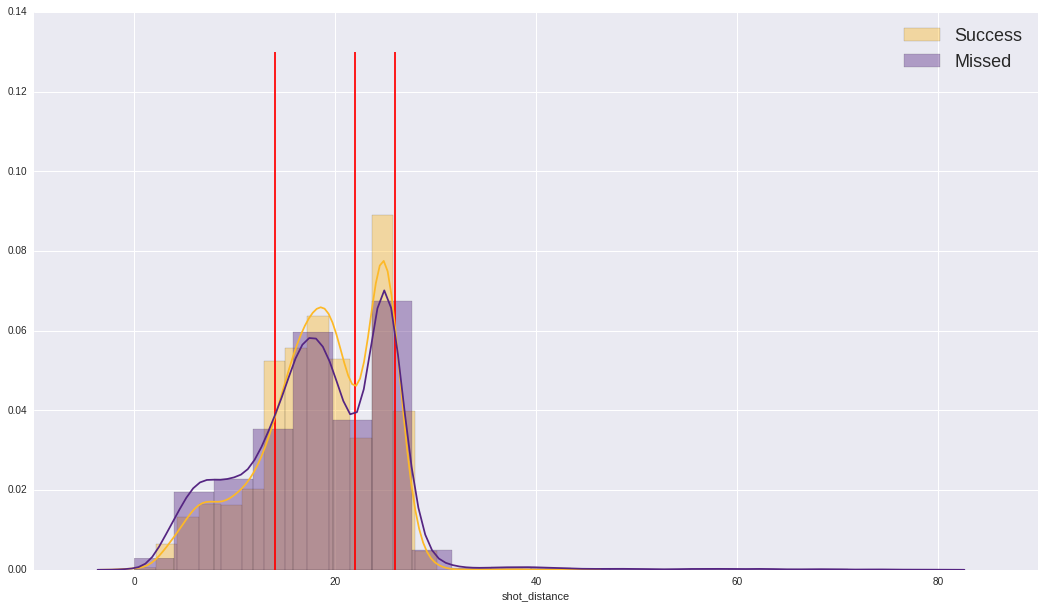

In [11]:
dist_df = data[data.action_type == 'Jump Shot']
plt.figure(figsize=(18,10))
sns.distplot(dist_df[dist_df['shot_made_flag']==1].shot_distance,bins=20,color='#FDB927',kde=True,label='Success')
sns.distplot(dist_df[dist_df['shot_made_flag']==0].shot_distance,bins=20,color='#552582',kde=True,label='Missed')

plt.vlines(x=[14,22,26], ymin=0.0,ymax=0.13, colors='r')

plt.legend(fontsize=18)
plt.show()

같은 jump shot 도 distance에 따라 <br>
0-14 : 'ShortJumpShot' <br>
14-22 : 'MediumJumpShot' <br>
22- : 'LongJumpShot' <br>

##### Gaussian Mixture를 이용한 shot_rage clustering

In [53]:
num_clusters=15
gmm = GMM(
    n_components=num_clusters,
    covariance_type='full',
    params='wmc',
    init_params='wmc',
    random_state=1,
    n_init=5,
    n_iter=150,
    verbose=0)

gmm.fit(data.loc[:, ['loc_x', 'loc_y']])

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=15, n_init=5, n_iter=150, params='wmc', random_state=1,
  thresh=None, tol=0.001, verbose=0)

In [54]:
gmm_result = gmm.predict(data.loc[:, ['loc_x', 'loc_y']]) 
data['shotLocationCluster'] = gmm_result

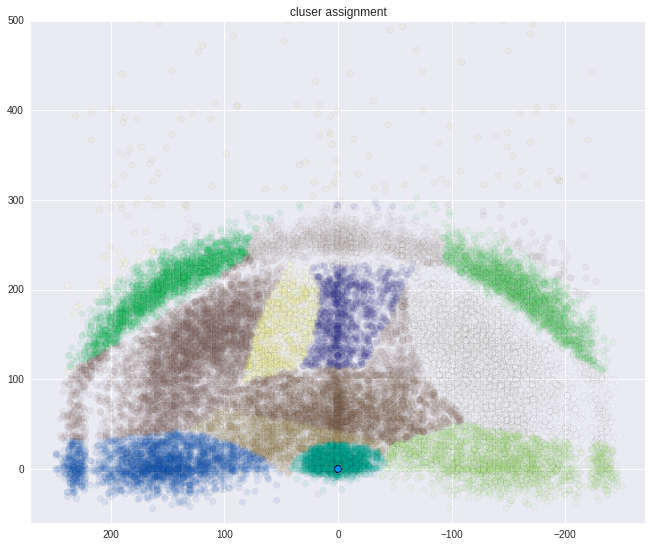

In [55]:
plt.rcParams['figure.figsize'] = (11, 9)

plt.figure()
plt.ylim(-60,500); plt.xlim(270,-270)
plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='terrain',alpha=0.1)

##### DBSCAN 을 이용한 clustering

In [12]:
db = DBSCAN(eps=10, min_samples=100).fit(data.loc[:, ['loc_x', 'loc_y']])

In [13]:
set(db.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [14]:
data['shotLocationCluster'] = db.labels_

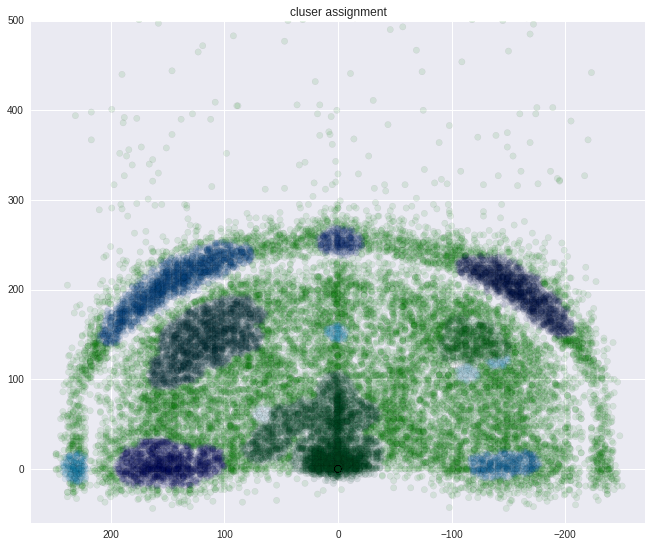

In [15]:
plt.rcParams['figure.figsize'] = (11, 9)

plt.figure()
plt.ylim(-60,500); plt.xlim(270,-270)
plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='ocean',alpha=0.1)

eps=10, min_samples=100 가 적당한 듯 <br>

## Feature Extraction

1)  categorize action_type

In [16]:
#1) 데이터 탐색
grouped = data['shot_made_flag'].groupby(data['action_type'])
meanByActionType = grouped.mean()
countByActionType = grouped.count()
meanByAction_df = meanByActionType.sort_values(ascending=False)

In [17]:
meanByAction = pd.DataFrame() 
meanByAction['action_type'] = meanByActionType.index
meanByAction['accByAction'] =  list(meanByActionType)
countByAction = pd.DataFrame() 
countByAction['action_type'] = countByActionType.index
countByAction['accByAction'] =  list(countByActionType)

In [18]:
ByAction_df = pd.merge(left = meanByAction, right = countByAction, how = 'left', left_on ='action_type', right_on='action_type')

In [19]:
ByAction_df.sort_values('accByAction_y', ascending=False)

,action_type,accByAction_x,accByAction_y
26,Jump Shot,0.326913,15836
27,Layup Shot,0.385330,2154
12,Driving Layup Shot,0.741400,1628
56,Turnaround Jump Shot,0.598204,891
17,Fadeaway Jump Shot,0.574541,872
41,Running Jump Shot,0.747112,779
29,Pullup Jump shot,0.723881,402
53,Turnaround Fadeaway shot,0.584699,366
47,Slam Dunk Shot,0.982036,334
34,Reverse Layup Shot,0.636637,333


In [20]:
#2) jump shot이 너무 많아서 binning 0-14 : 'ShortJumpShot'  14-22 : 'MediumJumpShot'  22- : 'LongJumpShot'  
def getJumpShotCategory(row, df):
    answer = ''
    if row['action_type'] == 'Jump Shot':
        if row['shot_distance'] < 14:
            answer = 'ShortJumpShot'
        elif row['shot_distance'] < 22:
            answer = 'MediumJumpShot'
        else:
            answer = 'LongJumpShot'
    else:
        answer = row['action_type']
    return answer

In [21]:
jumpshotCategory = data.apply(lambda row: getJumpShotCategory(row, data), axis=1)
data['jumpshotCategory'] = jumpshotCategory

In [22]:
grouped = data['shot_made_flag'].groupby(data['jumpshotCategory'])
meanByActionType2 = grouped.mean()
countByActionType2 = grouped.count()
meanByAction_df2 = meanByActionType2.sort_values(ascending=False)

In [23]:
#3) 빈도가 적은 Dunk Shoot 종류들은 Dunk Shoot으로 묶어줌
toDunk = ['Running Slam Dunk Shot','Putback Slam Dunk Shot','Putback Dunk Shot','Follow Up Dunk Shot',\
          'Reverse Slam Dunk Shot','Running Dunk Shot','Driving Slam Dunk Shot']

toDunkActionType = data.apply(lambda row: 'Dunk Shot' if row['jumpshotCategory'] in toDunk  else row['jumpshotCategory'], axis=1)
data['new_action_type'] = toDunkActionType

In [24]:
#4) 50미만이면 others 로 묶음
grouped = data['shot_made_flag'].groupby(data['new_action_type'])
meanByActionType3 = grouped.mean()
countByActionType3 = grouped.count()
meanByAction_df3 = meanByActionType3.sort_values(ascending=False)

otherActionType = list(countByActionType3[countByActionType3 < 50].index)
data['type'] = data.apply(lambda row: row['new_action_type'] if row['new_action_type'] not in otherActionType else 'otherActionType', axis=1)

2) 그 전에 슛을 성공했으면 1, 실패했으면 0, 정보가 없으면 2

In [25]:
# Calculate a vector of previous shots (probably could be done more efficient ...)
def get_prev_made_shot(row, df):
    game_id = row['game_id']
    game_event_id = row['game_event_id']
    
    game_df = df.loc[df['game_id'] == game_id].sort_values('game_event_id')
    prev_events_df = game_df.loc[game_df['game_event_id'] < game_event_id]
    
    # Was previous shot in game made?
    last = prev_events_df.tail(1)
    last_shot = last['shot_made_flag']
    
    # if game starts, or previous shot was unknown
    if (last_shot.empty):
        answer = "firstShot"
    elif pd.isnull(last_shot).any():
        answer = "noInfomation"
    elif int(last_shot.values[0]) == 0:
        answer = 'successBefore'
    elif int(last_shot.values[0]) == 1:
        answer = 'missedBefore'
    
    return answer

In [26]:
prev_shot_made_s = data.apply(lambda row: get_prev_made_shot(row, data), axis=1)
data['prev_shot_made'] = prev_shot_made_s

2) 에서 추출한 feature가 유의미한가?

In [27]:
grouped = data['shot_made_flag'].groupby(data['prev_shot_made'])

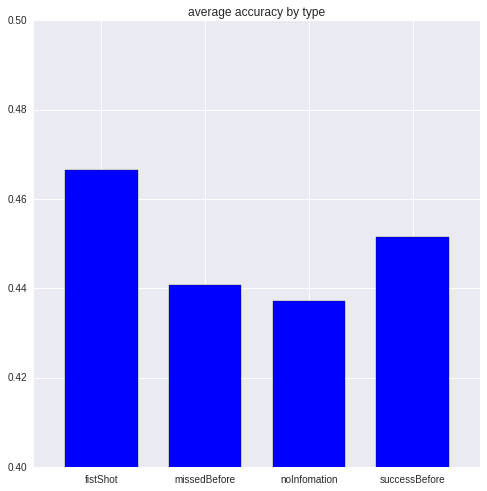

In [28]:
plt.rcParams['figure.figsize'] = (8, 8)

accuracyVec = np.array(grouped.mean())

barWidth = 0.7
xLocs = np.arange(len(accuracyVec))

fig, ax = plt.subplots()

ax.bar(xLocs, accuracyVec, barWidth, color='b')
ax.set_xticks(xLocs+0.5*barWidth)
ax.set_xticklabels(('fistShot', 'missedBefore', 'noInfomation','successBefore'))
plt.ylim([0.40,0.5]); plt.xlim([-0.3,4]); plt.title('average accuracy by type')

3) DBSCAN 을 활용하여 cluster 한 결과

In [29]:
db = DBSCAN(eps=10, min_samples=100).fit(data.loc[:, ['loc_x', 'loc_y']])
print("number of clusters : %s" %(len(list(set(db.labels_)))))
data['shotLocationCluster'] = db.labels_

number of clusters : 15


4) Distance 기준

In [30]:
#0~5, 5~9, 9~22, 22~29, 30 , 31이상
def getDistanceCategory(row, df):
    if row['shot_distance'] <= 5:
        answer = 'distance1'
    elif row['shot_distance'] <= 9:
        answer = 'distance2'
    elif row['shot_distance'] <= 22:
        answer = 'distance3'
    elif row['shot_distance'] <= 29:
        answer = 'distance4'
    elif row['shot_distance'] == 30:
        answer = 'distance5'
    elif row['shot_distance'] <= 45:
        answer = 'distance6'
    else:
        answer = 'distance7'
    return answer

In [31]:
distance_binning = data.apply(lambda row: getDistanceCategory(row, data), axis=1)
data['distance_binning'] = distance_binning

5) time remaining 3초 이하 or 이상

In [32]:
data['time_remaining'] = data.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)
data['last_moments'] = data.apply(lambda row: 1 if row['time_remaining'] <= 3 else 0, axis=1)

6) minute remaining

7) Season 정보 - 상 / 중 / 하

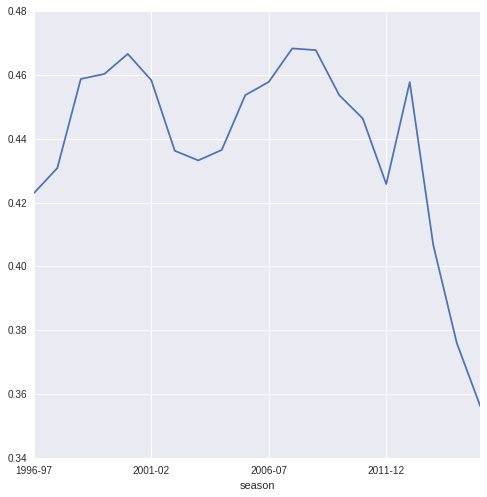

In [33]:
grouped = data['shot_made_flag'].groupby(data['season'])
grouped.mean().plot()
meanBySeason = grouped.mean().sort_values(ascending=False)

In [34]:
seasonDict = {}
for index, row in meanBySeason.iteritems():
    if row >=0.44:
        seasonDict[index] = 'BestSeason'
    elif row > 0.42:
        seasonDict[index] = 'GoodSeason'
    else:
        seasonDict[index] = 'BadSeason'

In [35]:
data['seasonCategory'] = data.apply(lambda row: seasonDict[row['season']], axis=1)

8) vs Opponent 정보 - veryEasy, Easy, Medium, Hard 등

In [36]:
grouped = data['shot_made_flag'].groupby(data['opponent'])
meanByOppo = grouped.mean()

meanByOppo_df = pd.DataFrame()
meanByOppo_df['acc'] = list(meanByOppo.index)
meanByOppo_df['opponent'] = list(meanByOppo.sort_values(ascending=False))

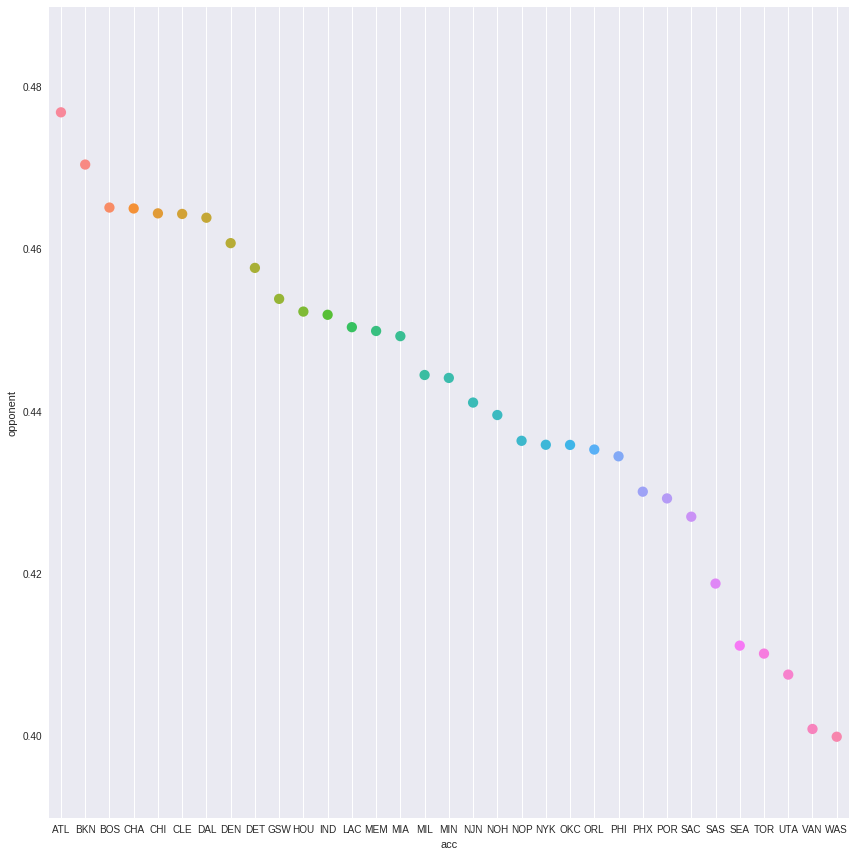

In [37]:
plt.figure(figsize=(10,10))
sns.factorplot(x='acc', y='opponent', data=meanByOppo_df, hue ='acc',size=12)
plt.grid()

In [38]:
opponentDict = {}
for index, row in meanByOppo.iteritems():
    if row >=0.47:
        opponentDict[index] = 'EasiestTeam'
    elif row > 0.46:
        opponentDict[index] = 'veryEasyTeam'
    elif row > 0.448:
        opponentDict[index] = 'EasyTeam'
    elif row > 0.436:
        opponentDict[index] = 'litteHardTeam'
    elif row > 0.427:
        opponentDict[index] = 'HardTeam'
    elif row > 0.405:
        opponentDict[index] = 'HarderTeam'
    else:
        opponentDict[index] = 'HardestTeam'

In [39]:
data['opponentCategory'] = data.apply(lambda row: opponentDict[row['opponent']], axis=1)

9) Home / Away

In [40]:
data['away'] = data.matchup.str.contains('@')

10) 오른쪽 / 왼쪽?

In [41]:
cutoff = 30

left = data[data.loc_x < -cutoff]
middle = data[np.array(data.loc_x >= -cutoff) * np.array(data.loc_x <= cutoff)]
right = data[data.loc_x > cutoff]

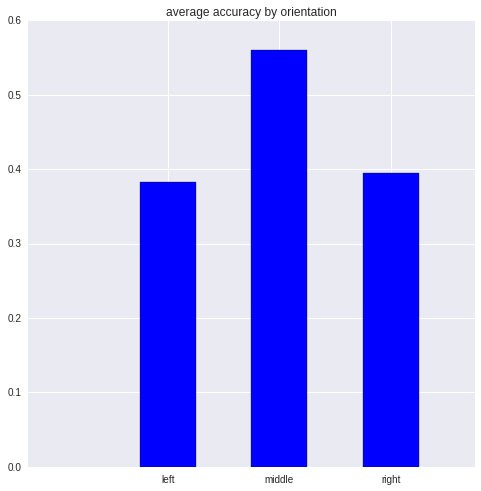

In [42]:
plt.rcParams['figure.figsize'] = (8, 8)

accuracyVec = np.array([np.mean(left.shot_made_flag), np.mean(middle.shot_made_flag), np.mean(right.shot_made_flag)])

barWidth = 0.5
xLocs = np.arange(len(accuracyVec))

fig, ax = plt.subplots()
ax.bar(xLocs, accuracyVec, barWidth, color='b')
ax.set_xticks(xLocs+0.5*barWidth)
ax.set_xticklabels(('left', 'middle', 'right'))
plt.xlim([-1,3]); plt.title('average accuracy by orientation')

In [43]:
def getDirection(row, df):
    if row['loc_x'] < -30:
        answer = 'left'
    elif row['loc_x'] > 30:
        answer = 'right'
    else:
        answer = 'middle'
    return answer

In [44]:
data['shot_direction'] = data.apply(lambda row: getDirection(row, data), axis=1)

11) play off

12) RealDistance

In [45]:
data['RealDistance'] = data.apply(lambda row: np.sqrt(row['loc_x']**2 + row['loc_y']**2), axis=1)

13) condition by game

In [33]:
''' 이 변수는 최종적으로 제외
아마도 overfitting 되는 듯
또한, 예측하는 슛 정보 다음 시점의 정보를 사용

grouped = data['shot_made_flag'].groupby(data['game_id'])
meanByGame = grouped.mean()

meanByGame_df = pd.DataFrame()
meanByGame_df['game_id'] = meanByGame.index
meanByGame_df['accByGame'] = list(meanByGame)

#NaN 값은 평균값으로 채워줌 test_x['accByActionType'] = test_x['accByActionType'].fillna(0.444)
meanByGame_df['accByGame'] = meanByGame_df['accByGame'].fillna(0.444)
s = meanByGame_df.sort_values('accByGame')

merged = pd.merge(left=data,right=meanByGame_df, how='left', left_on='game_id', right_on='game_id')
data = merged.copy()
'''

In [34]:
plt.figure(figsize=(10,10))

## necessary variables
N = len(list(meanByGame_df.index))
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
plt.bar(ind, s['accByGame'], width,
                    color='red')

# axes and labels
#plt.set_xlim(-width,len(ind)+width)
#ax.set_ylim(0,45)
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
#xTickMarks = ['Group'+str(i) for i in range(1,6)]
#ax.set_xticks(ind+width)
#xtickNames = ax.set_xticklabels(xTickMarks)
#plt.setp(xtickNames, rotation=45, fontsize=10)


<Container object of 1559 artists>

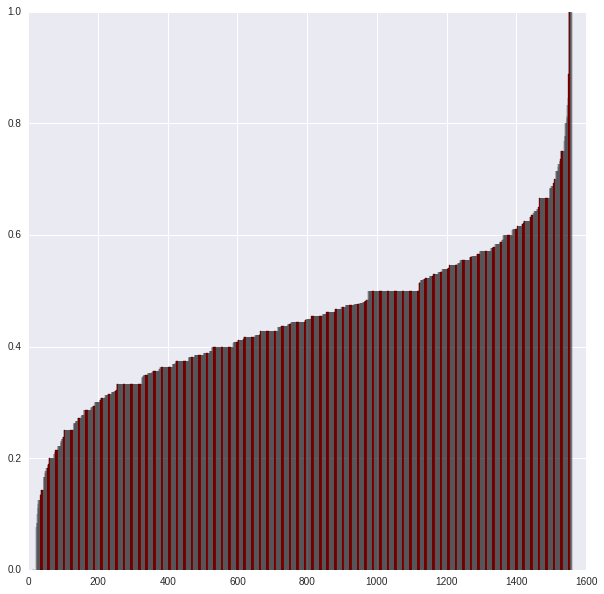

In [135]:
'''
def getCondition(row, df):
    if row['accByGame'] > 0.6:
        answer = 'bestCondition'
    elif row['accByGame'] > 0.5:
        answer = 'goodContion'
    elif row['accByGame'] > 0.33:
        answer = 'NotBadCondition'
    else:
        answer = 'BadCondition'
    return answer

data['dayCondition'] = data.apply(lambda row: getCondition(row, data), axis=1)
'''

0.5 초과  /  0.5 ~ 0.33초과  / 0.33포함 이하

# 필요없는 변수 제거 및 더미변수

In [46]:
df = data.copy()

In [47]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id',
       'loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_date',
       'matchup', 'opponent', 'shot_id', 'game_date_DT', 'dayOfWeek',
       'dayOfYear', 'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'shotLocationCluster', 'jumpshotCategory',
       'new_action_type', 'type', 'prev_shot_made', 'distance_binning',
       'time_remaining', 'last_moments', 'seasonCategory', 'opponentCategory',
       'away', 'shot_direction', 'RealDistance'],
      dtype='object')

In [48]:
real_features=['RealDistance','loc_x','loc_y','minutes_remaining']
category_features = ['period', 'playoffs',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'matchup', 'shotLocationCluster', 'type', 'prev_shot_made',
       'distance_binning', 'last_moments', 'seasonCategory',
       'opponentCategory', 'away', 'shot_direction']

In [49]:
process_df = df['shot_made_flag']

for f in category_features:
    process_df = pd.concat([process_df, pd.get_dummies(data[f], prefix=f),], axis=1)

In [50]:
final_data = pd.concat([process_df, df[real_features]], axis = 1)

In [51]:
train = final_data[-pd.isnull(process_df.shot_made_flag)]
train_x = train.drop('shot_made_flag', axis=1)
train_y = train.shot_made_flag

In [52]:
train_x.shape

(25697, 178)

## Feaure Selection

.

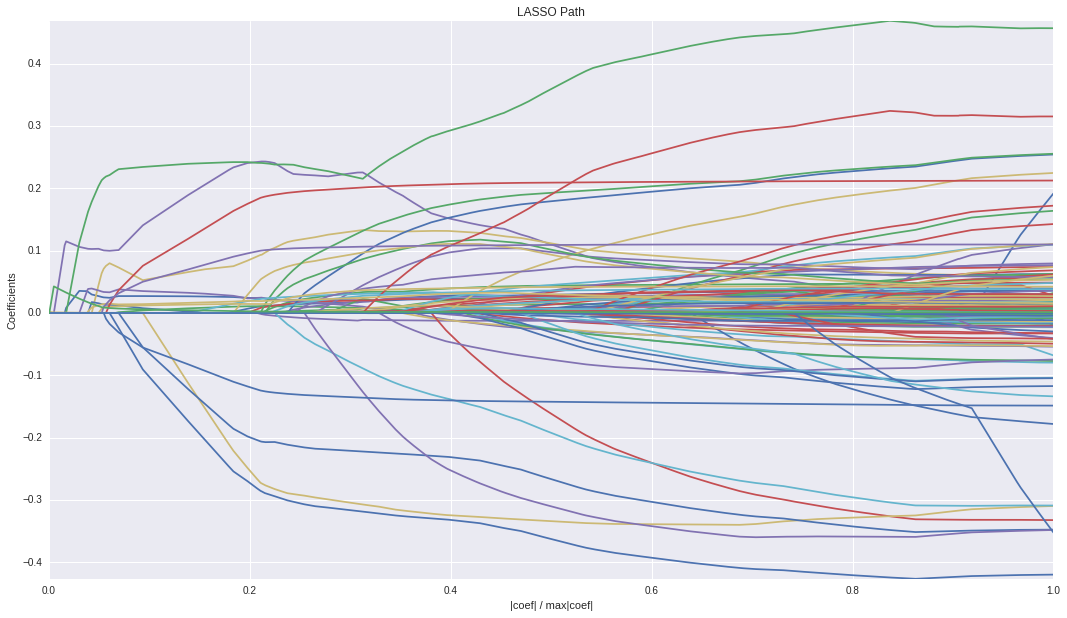

In [144]:
#2) lasso path
from sklearn import linear_model
alphas, _, coefs = linear_model.lars_path(np.array(train_x), np.array(train_y), method='lasso', verbose=True)

plt.figure(figsize=(18,10))
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
#plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [145]:
clf = linear_model.Lasso(alpha=0.00004)
clf.fit(np.array(train_x), np.array(train_y))

Lasso(alpha=4e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [146]:
selectedFeatures = train_x.columns[clf.coef_ > 0]

In [147]:
train_x.shape

(25697, 182)

In [148]:
selectedFeatures

Index(['period_1', 'period_2', 'period_3', 'playoffs_0',
       'shot_type_2PT Field Goal', 'shot_zone_area_Center(C)',
       'shot_zone_area_Left Side Center(LC)',
       'shot_zone_area_Right Side Center(RC)',
       'shot_zone_basic_In The Paint (Non-RA)',
       'shot_zone_basic_Left Corner 3', 'shot_zone_basic_Restricted Area',
       'shot_zone_range_16-24 ft.', 'shot_zone_range_8-16 ft.',
       'matchup_LAL @ CHA', 'matchup_LAL @ CHH', 'matchup_LAL @ CHI',
       'matchup_LAL @ IND', 'matchup_LAL @ MIL', 'matchup_LAL @ NOH',
       'matchup_LAL @ NOK', 'matchup_LAL @ NOP', 'matchup_LAL @ NYK',
       'matchup_LAL @ PHO', 'matchup_LAL @ PHX', 'matchup_LAL @ SAC',
       'matchup_LAL @ SAS', 'matchup_LAL @ SEA', 'matchup_LAL @ UTA',
       'matchup_LAL @ UTH', 'matchup_LAL @ WAS', 'matchup_LAL vs. CHH',
       'matchup_LAL vs. DAL', 'matchup_LAL vs. GSW', 'matchup_LAL vs. MIN',
       'matchup_LAL vs. NOK', 'matchup_LAL vs. ORL', 'matchup_LAL vs. PHI',
       'matchup_LAL vs. PH

In [54]:
#model training set
X = train_x
y = train_y

In [55]:
X.shape

(25697, 178)

##### model selection

In [71]:
clf = XGBClassifier(max_depth=9, learning_rate=0.012, n_estimators=500, subsample=0.62, colsample_bytree=0.6, seed=5)
clf.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.012, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=111, silent=True, subsample=0.62)

In [72]:
#training error
log_loss(y, clf.predict_proba(X))

0.54375941582230247

In [73]:
target_x = final_data[pd.isnull(process_df.shot_made_flag)]
target_x2 = target_x.drop('shot_made_flag', axis=1)
target_y = clf.predict_proba(target_x2)[:,1]

target_id = df[pd.isnull(df.shot_made_flag)].shot_id
submission = pd.DataFrame({"shot_id":target_id, "shot_made_flag":target_y})
submission.sort_values('shot_id',  inplace=True)
submission.to_csv("submit.csv",index=False) 